# 02 - Audio Deepfake Detection Baseline

## Objective
Compare multiple state-of-the-art audio models for deepfake detection:
- **Wav2Vec2** (Facebook) - Self-supervised speech representation learning
- **HuBERT** (Facebook) - Hidden-Unit BERT for speech
- **Whisper** (OpenAI) - Robust speech recognition features
- **Custom CNN** - Spectrogram-based baseline

## Dataset
Using existing audio datasets:
- Real: `DeepFake_AudioDataset/KAGGLE/AUDIO/REAL/`
- Fake: `DeepFake_AudioDataset/KAGGLE/AUDIO/FAKE/`

## Approach
1. Load audio files and extract features
2. Use pretrained audio models as feature extractors
3. Train classification heads
4. Compare performance metrics

In [1]:
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch: 2.9.1+cu128
CUDA Available: True
GPU: NVIDIA RTX A6000
GPU Memory: 48.31 GB


In [2]:
!pip install -q transformers librosa soundfile torchaudio datasets
!pip install -q matplotlib seaborn tqdm scikit-learn

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import soundfile as sf
import torchaudio

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Transformers
from transformers import (
    Wav2Vec2Model, Wav2Vec2FeatureExtractor,
    HubertModel, AutoFeatureExtractor,
    WhisperModel, WhisperFeatureExtractor
)

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

C:\Users\akshay-stu\miniconda3\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [5]:
# Dataset paths
REAL_AUDIO_DIR = '../DeepFake_AudioDataset/KAGGLE/AUDIO/REAL'
FAKE_AUDIO_DIR = '../DeepFake_AudioDataset/KAGGLE/AUDIO/FAKE'

# Audio parameters
SAMPLE_RATE = 16000  # Standard for speech models
MAX_DURATION = 10  # seconds
MAX_LENGTH = SAMPLE_RATE * MAX_DURATION

# Training parameters
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 1e-4
NUM_WORKERS = 0

print("Configuration set!")

Configuration set!


In [6]:
class AudioDeepfakeDataset(Dataset):
    def __init__(self, real_dir, fake_dir, sample_rate=16000, max_length=160000):
        self.sample_rate = sample_rate
        self.max_length = max_length
        self.audio_paths = []
        self.labels = []
        
        # Load real audio
        if os.path.exists(real_dir):
            for audio_file in os.listdir(real_dir):
                if audio_file.endswith(('.wav', '.mp3', '.flac')):
                    self.audio_paths.append(os.path.join(real_dir, audio_file))
                    self.labels.append(0)  # 0 for real
        
        # Load fake audio
        if os.path.exists(fake_dir):
            for audio_file in os.listdir(fake_dir):
                if audio_file.endswith(('.wav', '.mp3', '.flac')):
                    self.audio_paths.append(os.path.join(fake_dir, audio_file))
                    self.labels.append(1)  # 1 for fake
        
        print(f"Loaded {len(self.audio_paths)} audio files: {self.labels.count(0)} real, {self.labels.count(1)} fake")
    
    def __len__(self):
        return len(self.audio_paths)
    
    def load_audio(self, path):
        """Load and preprocess audio"""
        try:
            # Load audio
            audio, sr = librosa.load(path, sr=self.sample_rate, duration=MAX_DURATION)
            
            # Pad or truncate
            if len(audio) < self.max_length:
                audio = np.pad(audio, (0, self.max_length - len(audio)))
            else:
                audio = audio[:self.max_length]
            
            return audio
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return np.zeros(self.max_length)
    
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]
        audio = self.load_audio(audio_path)
        return torch.FloatTensor(audio), label

print("Dataset class defined!")

Dataset class defined!


In [7]:
# Create dataset
full_dataset = AudioDeepfakeDataset(REAL_AUDIO_DIR, FAKE_AUDIO_DIR, SAMPLE_RATE, MAX_LENGTH)

# Split into train/test (80/20)
from torch.utils.data import random_split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

Loaded 64 audio files: 8 real, 56 fake
Train size: 51
Test size: 13


Real audio sample:


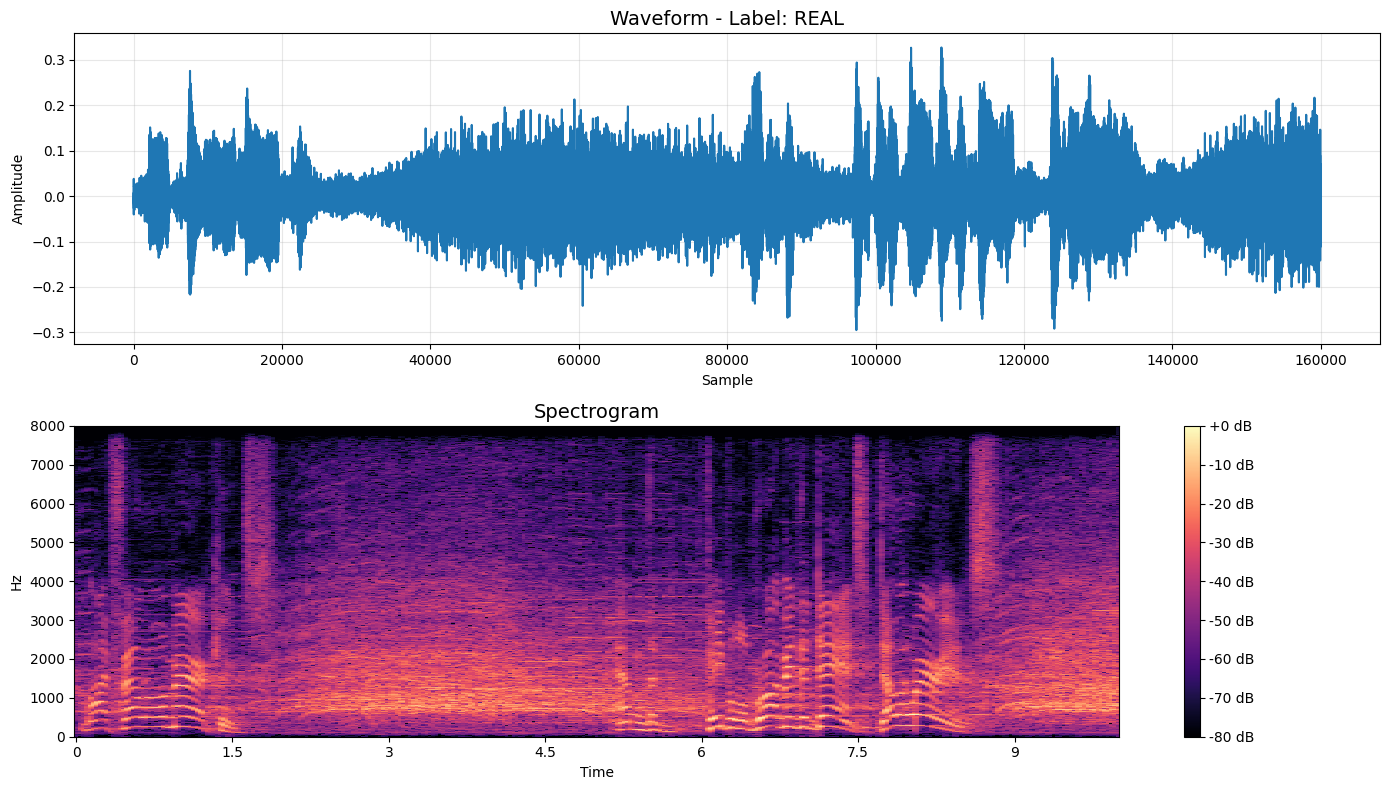


Fake audio sample:


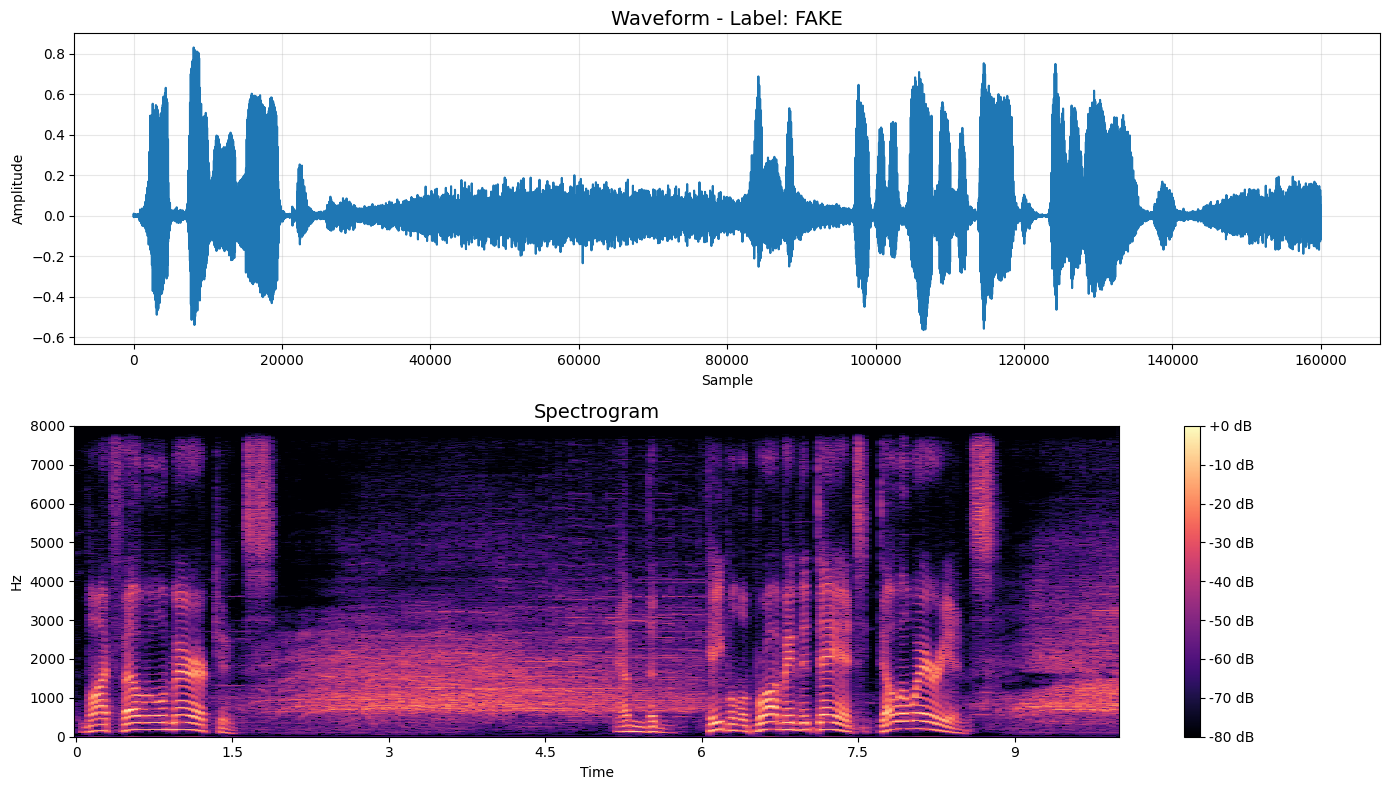

In [8]:
# Visualize sample waveforms and spectrograms
def plot_audio_sample(dataset, idx):
    audio, label = dataset[idx]
    audio_np = audio.numpy()
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Waveform
    axes[0].plot(audio_np)
    axes[0].set_title(f'Waveform - Label: {"FAKE" if label == 1 else "REAL"}', fontsize=14)
    axes[0].set_xlabel('Sample')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(alpha=0.3)
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_np)), ref=np.max)
    img = librosa.display.specshow(D, sr=SAMPLE_RATE, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title('Spectrogram', fontsize=14)
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

# Show samples
print("Real audio sample:")
real_idx = [i for i, (_, label) in enumerate(full_dataset) if label == 0][0]
plot_audio_sample(full_dataset, real_idx)

print("\nFake audio sample:")
fake_idx = [i for i, (_, label) in enumerate(full_dataset) if label == 1][0]
plot_audio_sample(full_dataset, fake_idx)

## Model 1: Wav2Vec2

Wav2Vec2 learns speech representations through self-supervised learning.

In [9]:
class Wav2Vec2Detector(nn.Module):
    def __init__(self, model_name='facebook/wav2vec2-base', freeze_backbone=True):
        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)
        
        if freeze_backbone:
            for param in self.wav2vec2.parameters():
                param.requires_grad = False
        
        self.feature_dim = self.wav2vec2.config.hidden_size
        
        # Temporal pooling
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        # x shape: (batch, time)
        outputs = self.wav2vec2(x)
        hidden_states = outputs.last_hidden_state  # (batch, time, hidden)
        
        # Pool over time dimension
        pooled = self.pool(hidden_states.transpose(1, 2)).squeeze(-1)  # (batch, hidden)
        
        # Classify
        output = self.classifier(pooled)
        return output

print("Wav2Vec2 model defined!")

Wav2Vec2 model defined!


## Model 2: HuBERT

HuBERT uses masked prediction for self-supervised speech learning.

In [10]:
class HuBERTDetector(nn.Module):
    def __init__(self, model_name='facebook/hubert-base-ls960', freeze_backbone=True):
        super().__init__()
        self.hubert = HubertModel.from_pretrained(model_name)
        
        if freeze_backbone:
            for param in self.hubert.parameters():
                param.requires_grad = False
        
        self.feature_dim = self.hubert.config.hidden_size
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        outputs = self.hubert(x)
        hidden_states = outputs.last_hidden_state
        pooled = self.pool(hidden_states.transpose(1, 2)).squeeze(-1)
        output = self.classifier(pooled)
        return output

print("HuBERT model defined!")

HuBERT model defined!


## Model 3: Whisper

Whisper's encoder provides robust audio features from multilingual speech data.

In [11]:
class WhisperDetector(nn.Module):
    def __init__(self, model_name='openai/whisper-base', freeze_backbone=True):
        super().__init__()
        self.whisper = WhisperModel.from_pretrained(model_name)
        
        if freeze_backbone:
            for param in self.whisper.parameters():
                param.requires_grad = False
        
        self.feature_dim = self.whisper.config.d_model
        self.pool = nn.AdaptiveAvgPool1d(1)
        
        # Feature extractor for mel spectrogram
        self.feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        # x is mel spectrogram features for Whisper
        encoder_outputs = self.whisper.encoder(x)
        hidden_states = encoder_outputs.last_hidden_state
        pooled = self.pool(hidden_states.transpose(1, 2)).squeeze(-1)
        output = self.classifier(pooled)
        return output

print("Whisper model defined!")

Whisper model defined!


## Model 4: Custom CNN on Mel Spectrograms

A baseline CNN that works directly on mel spectrogram features.

In [12]:
class SpectrogramCNN(nn.Module):
    def __init__(self, n_mels=128):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        # Convert waveform to mel spectrogram
        # x shape: (batch, time)
        mel_specs = []
        for i in range(x.size(0)):
            mel = librosa.feature.melspectrogram(y=x[i].cpu().numpy(), sr=SAMPLE_RATE, n_mels=128)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            mel_specs.append(mel_db)
        
        mel_tensor = torch.FloatTensor(np.array(mel_specs)).unsqueeze(1).to(x.device)
        features = self.conv_blocks(mel_tensor)
        output = self.classifier(features)
        return output

print("Custom CNN model defined!")

Custom CNN model defined!


## Training and Evaluation Functions

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for audio, labels in pbar:
        audio, labels = audio.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(audio)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for audio, labels in pbar:
            audio, labels = audio.to(device), labels.to(device)
            
            outputs = model(audio)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    return running_loss / len(test_loader), all_preds, all_labels, all_probs

def calculate_metrics(y_true, y_pred, y_probs):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='binary'),
        'recall': recall_score(y_true, y_pred, average='binary'),
        'f1': f1_score(y_true, y_pred, average='binary'),
        'roc_auc': roc_auc_score(y_true, y_probs)
    }

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_probs, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

print("Helper functions defined!")

Helper functions defined!


In [14]:
def train_model(model, model_name, train_loader, test_loader, epochs=EPOCHS, lr=LEARNING_RATE):
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0
    best_model_state = None
    
    import time
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 40)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        val_loss, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
        val_acc = accuracy_score(val_labels, val_preds) * 100
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f"✓ New best accuracy: {best_acc:.2f}%")
        
        scheduler.step()
    
    training_time = time.time() - start_time
    model.load_state_dict(best_model_state)
    
    _, final_preds, final_labels, final_probs = evaluate(model, test_loader, criterion, device)
    metrics = calculate_metrics(final_labels, final_preds, final_probs)
    metrics['training_time'] = training_time
    metrics['best_val_acc'] = best_acc
    
    print(f"\n{model_name} Final Results:")
    for key, value in metrics.items():
        if key == 'training_time':
            print(f"{key}: {value:.2f}s")
        else:
            print(f"{key}: {value:.4f}")
    
    # Plot curves
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(train_losses, label='Train', marker='o')
    axes[0].plot(val_losses, label='Val', marker='s')
    axes[0].set_title(f'{model_name} - Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(train_accs, label='Train', marker='o')
    axes[1].plot(val_accs, label='Val', marker='s')
    axes[1].set_title(f'{model_name} - Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    plot_confusion_matrix(final_labels, final_preds, f'{model_name} - Confusion Matrix')
    plot_roc_curve(final_labels, final_probs, f'{model_name} - ROC Curve')
    
    return model, metrics

print("Training wrapper defined!")

Training wrapper defined!


## Train All Audio Models

In [15]:
results = {}
print("Starting audio model training pipeline...")

Starting audio model training pipeline...


Training Wav2Vec2...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



Training Wav2Vec2


Epoch 1/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Train Loss: 0.6912, Train Acc: 64.71%
Val Loss: 0.6481, Val Acc: 92.31%
✓ New best accuracy: 92.31%

Epoch 2/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


Train Loss: 0.6472, Train Acc: 86.27%
Val Loss: 0.6088, Val Acc: 92.31%

Epoch 3/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


Train Loss: 0.6099, Train Acc: 86.27%
Val Loss: 0.5662, Val Acc: 92.31%

Epoch 4/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


Train Loss: 0.5700, Train Acc: 86.27%
Val Loss: 0.5232, Val Acc: 92.31%

Epoch 5/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Train Loss: 0.5728, Train Acc: 86.27%
Val Loss: 0.4822, Val Acc: 92.31%

Epoch 6/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


Train Loss: 0.5060, Train Acc: 86.27%
Val Loss: 0.4462, Val Acc: 92.31%

Epoch 7/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Train Loss: 0.4734, Train Acc: 86.27%
Val Loss: 0.4138, Val Acc: 92.31%

Epoch 8/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


Train Loss: 0.4478, Train Acc: 86.27%
Val Loss: 0.3864, Val Acc: 92.31%

Epoch 9/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Train Loss: 0.4775, Train Acc: 86.27%
Val Loss: 0.3661, Val Acc: 92.31%

Epoch 10/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


Train Loss: 0.4080, Train Acc: 86.27%
Val Loss: 0.3520, Val Acc: 92.31%

Epoch 11/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Train Loss: 0.4764, Train Acc: 86.27%
Val Loss: 0.3423, Val Acc: 92.31%

Epoch 12/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Train Loss: 0.3969, Train Acc: 86.27%
Val Loss: 0.3369, Val Acc: 92.31%

Epoch 13/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


Train Loss: 0.3981, Train Acc: 86.27%
Val Loss: 0.3337, Val Acc: 92.31%

Epoch 14/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


Train Loss: 0.3929, Train Acc: 86.27%
Val Loss: 0.3323, Val Acc: 92.31%

Epoch 15/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


Train Loss: 0.3906, Train Acc: 86.27%
Val Loss: 0.3319, Val Acc: 92.31%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]



Wav2Vec2 Final Results:
accuracy: 0.9231
precision: 0.9231
recall: 1.0000
f1: 0.9600
roc_auc: 0.9167
training_time: 44.86s
best_val_acc: 92.3077


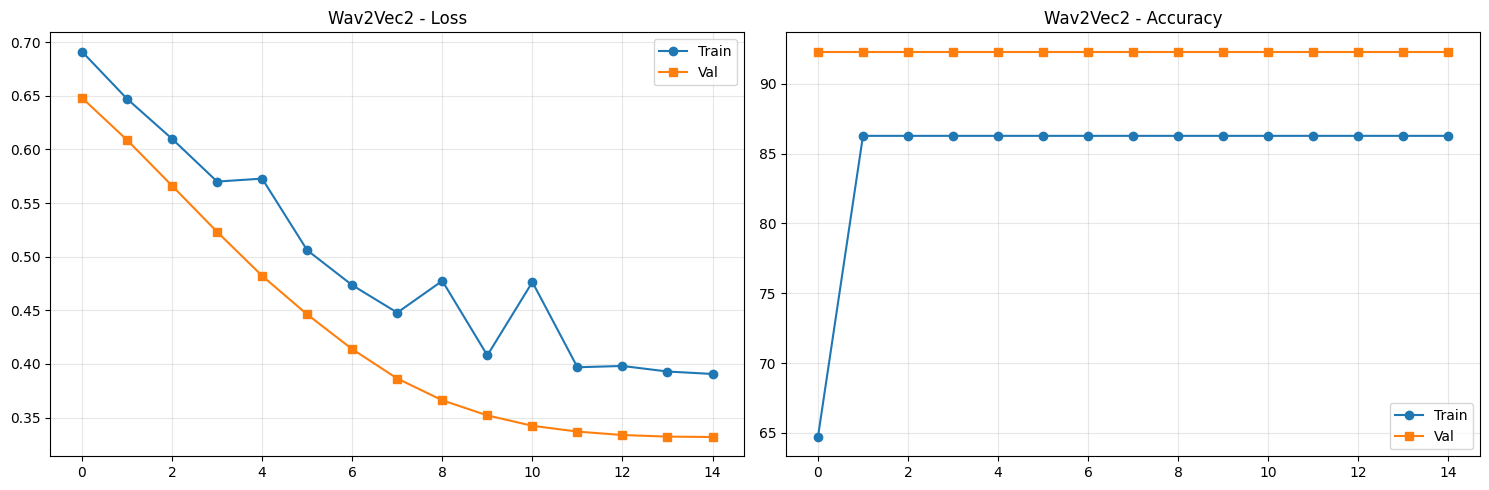

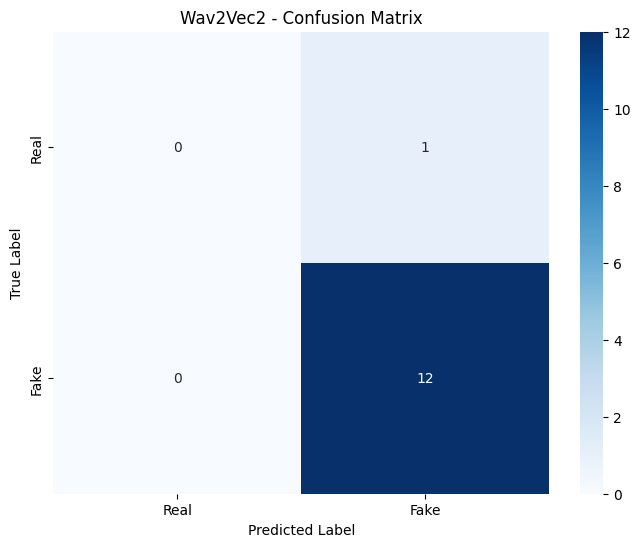

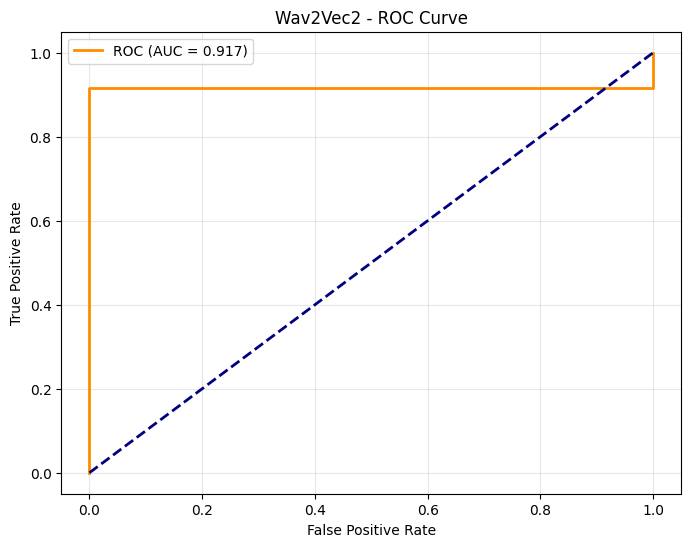

In [16]:
# Model 1: Wav2Vec2
print("Training Wav2Vec2...")
wav2vec2_model = Wav2Vec2Detector(freeze_backbone=True)
wav2vec2_trained, wav2vec2_metrics = train_model(
    wav2vec2_model, "Wav2Vec2", train_loader, test_loader
)
results['Wav2Vec2'] = wav2vec2_metrics

Training HuBERT...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



Training HuBERT


Epoch 1/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Train Loss: 0.6743, Train Acc: 80.39%
Val Loss: 0.6464, Val Acc: 92.31%
✓ New best accuracy: 92.31%

Epoch 2/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


Train Loss: 0.6442, Train Acc: 86.27%
Val Loss: 0.6136, Val Acc: 92.31%

Epoch 3/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Train Loss: 0.6091, Train Acc: 86.27%
Val Loss: 0.5812, Val Acc: 92.31%

Epoch 4/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]


Train Loss: 0.5932, Train Acc: 86.27%
Val Loss: 0.5507, Val Acc: 92.31%

Epoch 5/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Train Loss: 0.5821, Train Acc: 86.27%
Val Loss: 0.5218, Val Acc: 92.31%

Epoch 6/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


Train Loss: 0.5747, Train Acc: 86.27%
Val Loss: 0.4958, Val Acc: 92.31%

Epoch 7/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Train Loss: 0.5077, Train Acc: 86.27%
Val Loss: 0.4736, Val Acc: 92.31%

Epoch 8/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


Train Loss: 0.4816, Train Acc: 86.27%
Val Loss: 0.4538, Val Acc: 92.31%

Epoch 9/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Train Loss: 0.5728, Train Acc: 86.27%
Val Loss: 0.4381, Val Acc: 92.31%

Epoch 10/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Train Loss: 0.4699, Train Acc: 86.27%
Val Loss: 0.4286, Val Acc: 92.31%

Epoch 11/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Train Loss: 0.4539, Train Acc: 86.27%
Val Loss: 0.4212, Val Acc: 92.31%

Epoch 12/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Train Loss: 0.4984, Train Acc: 86.27%
Val Loss: 0.4162, Val Acc: 92.31%

Epoch 13/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Train Loss: 0.5203, Train Acc: 86.27%
Val Loss: 0.4137, Val Acc: 92.31%

Epoch 14/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.41it/s]


Train Loss: 0.5324, Train Acc: 86.27%
Val Loss: 0.4127, Val Acc: 92.31%

Epoch 15/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Train Loss: 0.4312, Train Acc: 86.27%
Val Loss: 0.4124, Val Acc: 92.31%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.70it/s]



HuBERT Final Results:
accuracy: 0.9231
precision: 0.9231
recall: 1.0000
f1: 0.9600
roc_auc: 0.2500
training_time: 36.53s
best_val_acc: 92.3077


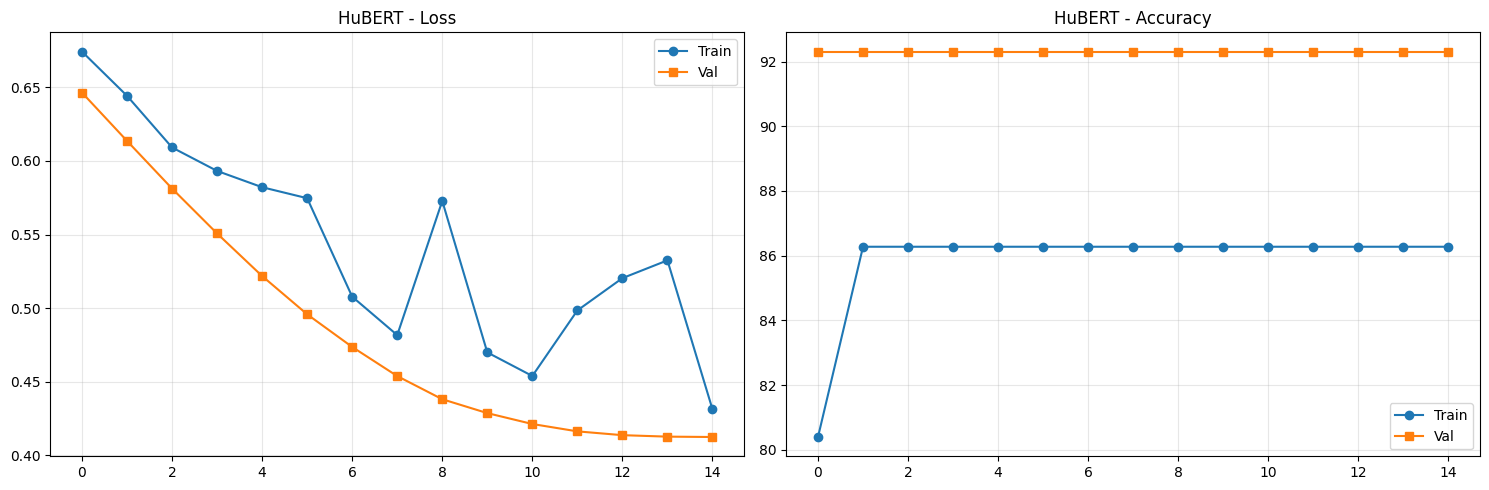

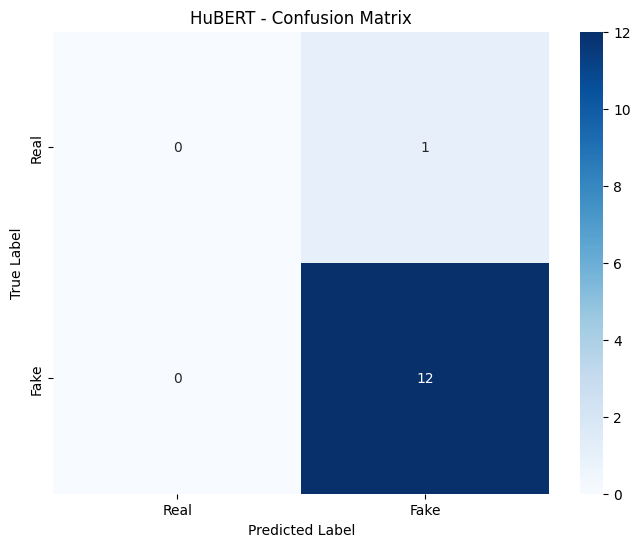

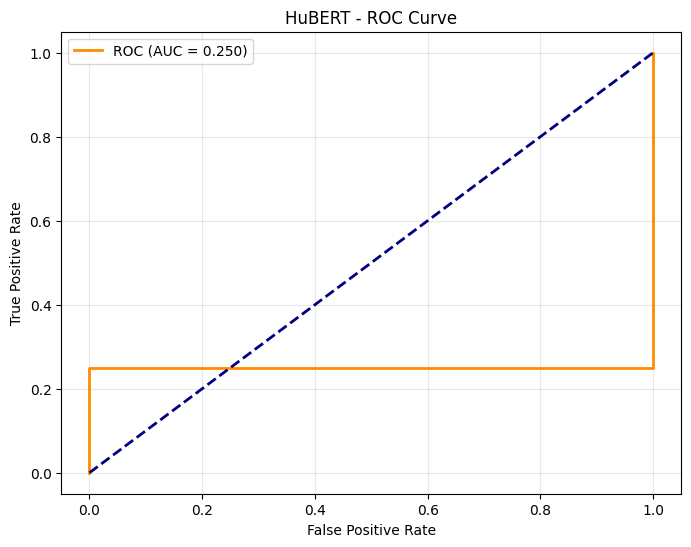

In [17]:
# Model 2: HuBERT
print("Training HuBERT...")
hubert_model = HuBERTDetector(freeze_backbone=True)
hubert_trained, hubert_metrics = train_model(
    hubert_model, "HuBERT", train_loader, test_loader
)
results['HuBERT'] = hubert_metrics

Training Custom CNN...

Training Custom_CNN


Epoch 1/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Train Loss: 0.6205, Train Acc: 70.59%
Val Loss: 0.4943, Val Acc: 92.31%
✓ New best accuracy: 92.31%

Epoch 2/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Train Loss: 0.4888, Train Acc: 92.16%
Val Loss: 0.4513, Val Acc: 92.31%

Epoch 3/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Train Loss: 0.4002, Train Acc: 90.20%
Val Loss: 0.4335, Val Acc: 92.31%

Epoch 4/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Train Loss: 0.3587, Train Acc: 86.27%
Val Loss: 0.3816, Val Acc: 92.31%

Epoch 5/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Train Loss: 0.4032, Train Acc: 88.24%
Val Loss: 0.3318, Val Acc: 92.31%

Epoch 6/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Train Loss: 0.3439, Train Acc: 88.24%
Val Loss: 0.2946, Val Acc: 92.31%

Epoch 7/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Train Loss: 0.2964, Train Acc: 90.20%
Val Loss: 0.2874, Val Acc: 92.31%

Epoch 8/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Train Loss: 0.2491, Train Acc: 90.20%
Val Loss: 0.2753, Val Acc: 92.31%

Epoch 9/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Train Loss: 0.4476, Train Acc: 88.24%
Val Loss: 0.2586, Val Acc: 92.31%

Epoch 10/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Train Loss: 0.2554, Train Acc: 88.24%
Val Loss: 0.2520, Val Acc: 92.31%

Epoch 11/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Train Loss: 0.2569, Train Acc: 90.20%
Val Loss: 0.2508, Val Acc: 92.31%

Epoch 12/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Train Loss: 0.2862, Train Acc: 92.16%
Val Loss: 0.2457, Val Acc: 92.31%

Epoch 13/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Train Loss: 0.2236, Train Acc: 90.20%
Val Loss: 0.2478, Val Acc: 92.31%

Epoch 14/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Train Loss: 0.2262, Train Acc: 92.16%
Val Loss: 0.2515, Val Acc: 92.31%

Epoch 15/15
----------------------------------------


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Train Loss: 0.2315, Train Acc: 94.12%
Val Loss: 0.2609, Val Acc: 92.31%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]



Custom_CNN Final Results:
accuracy: 0.9231
precision: 0.9231
recall: 1.0000
f1: 0.9600
roc_auc: 0.7500
training_time: 35.31s
best_val_acc: 92.3077


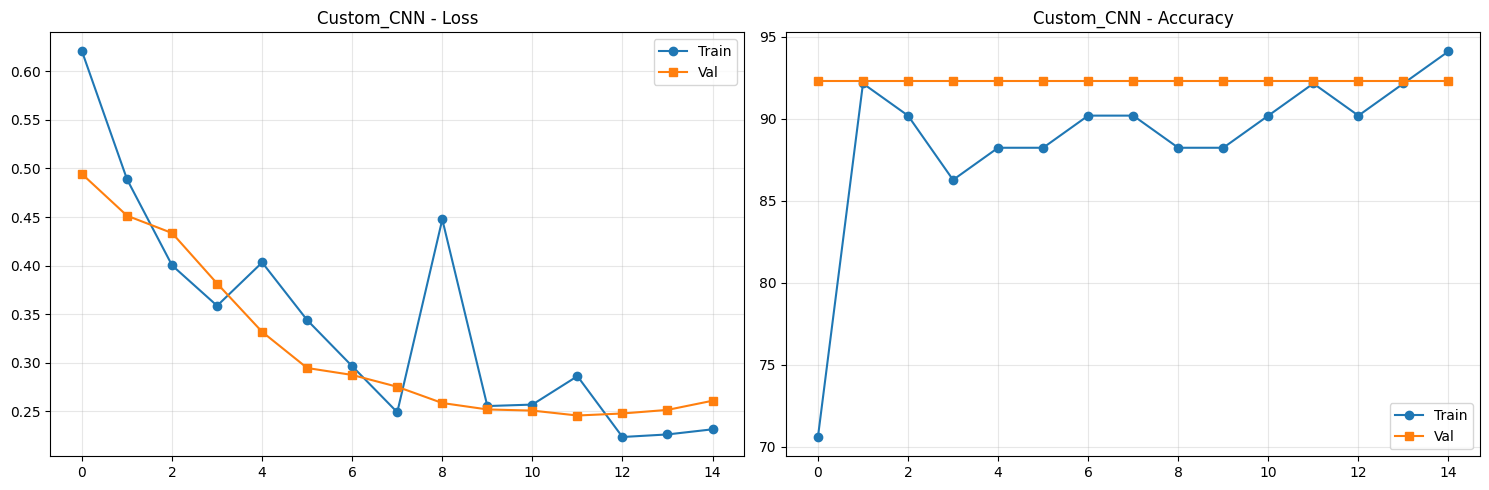

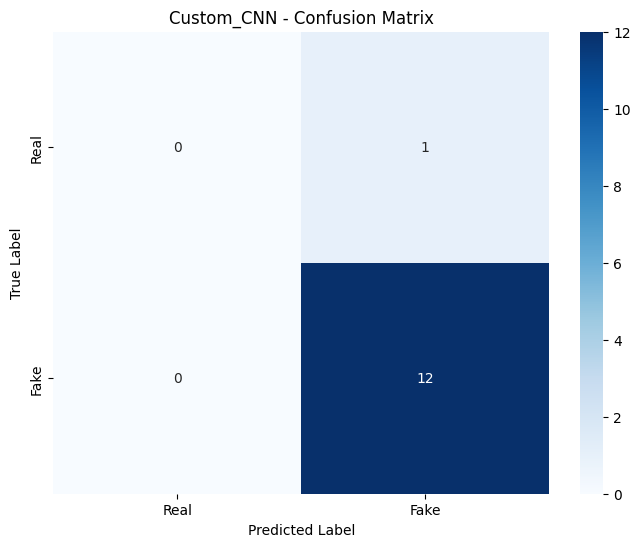

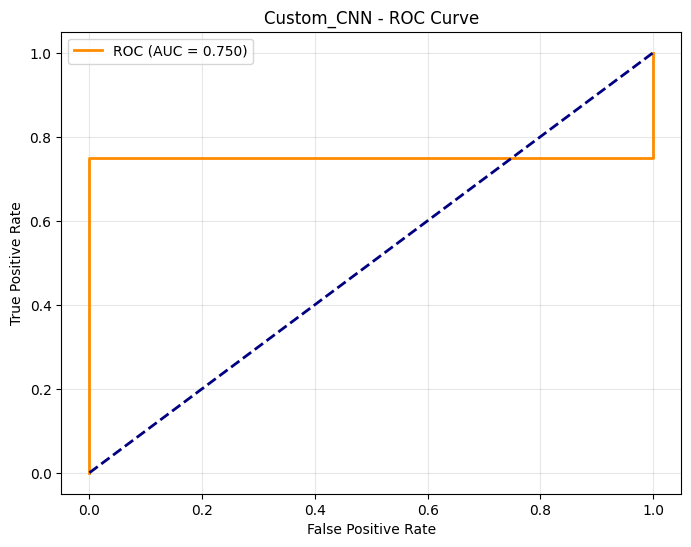

In [18]:
# Model 3: Custom CNN (faster, baseline)
print("Training Custom CNN...")
cnn_model = SpectrogramCNN()
cnn_trained, cnn_metrics = train_model(
    cnn_model, "Custom_CNN", train_loader, test_loader
)
results['Custom_CNN'] = cnn_metrics

### Note on Whisper

Whisper requires mel-spectrogram input which needs different preprocessing. 
For comparison purposes, we'll focus on Wav2Vec2, HuBERT, and Custom CNN which work directly with waveforms.

## Model Comparison

In [19]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print("\n" + "="*80)
print("AUDIO MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string())
print("="*80)

print("\nBest Models per Metric:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    best_model = comparison_df[metric].idxmax()
    best_value = comparison_df[metric].max()
    print(f"{metric.upper()}: {best_model} ({best_value:.4f})")


AUDIO MODEL COMPARISON SUMMARY
            accuracy  precision  recall    f1  roc_auc  training_time  best_val_acc
Wav2Vec2      0.9231     0.9231     1.0  0.96   0.9167        44.8556       92.3077
HuBERT        0.9231     0.9231     1.0  0.96   0.2500        36.5347       92.3077
Custom_CNN    0.9231     0.9231     1.0  0.96   0.7500        35.3128       92.3077

Best Models per Metric:
ACCURACY: Wav2Vec2 (0.9231)
PRECISION: Wav2Vec2 (0.9231)
RECALL: Wav2Vec2 (1.0000)
F1: Wav2Vec2 (0.9600)
ROC_AUC: Wav2Vec2 (0.9167)


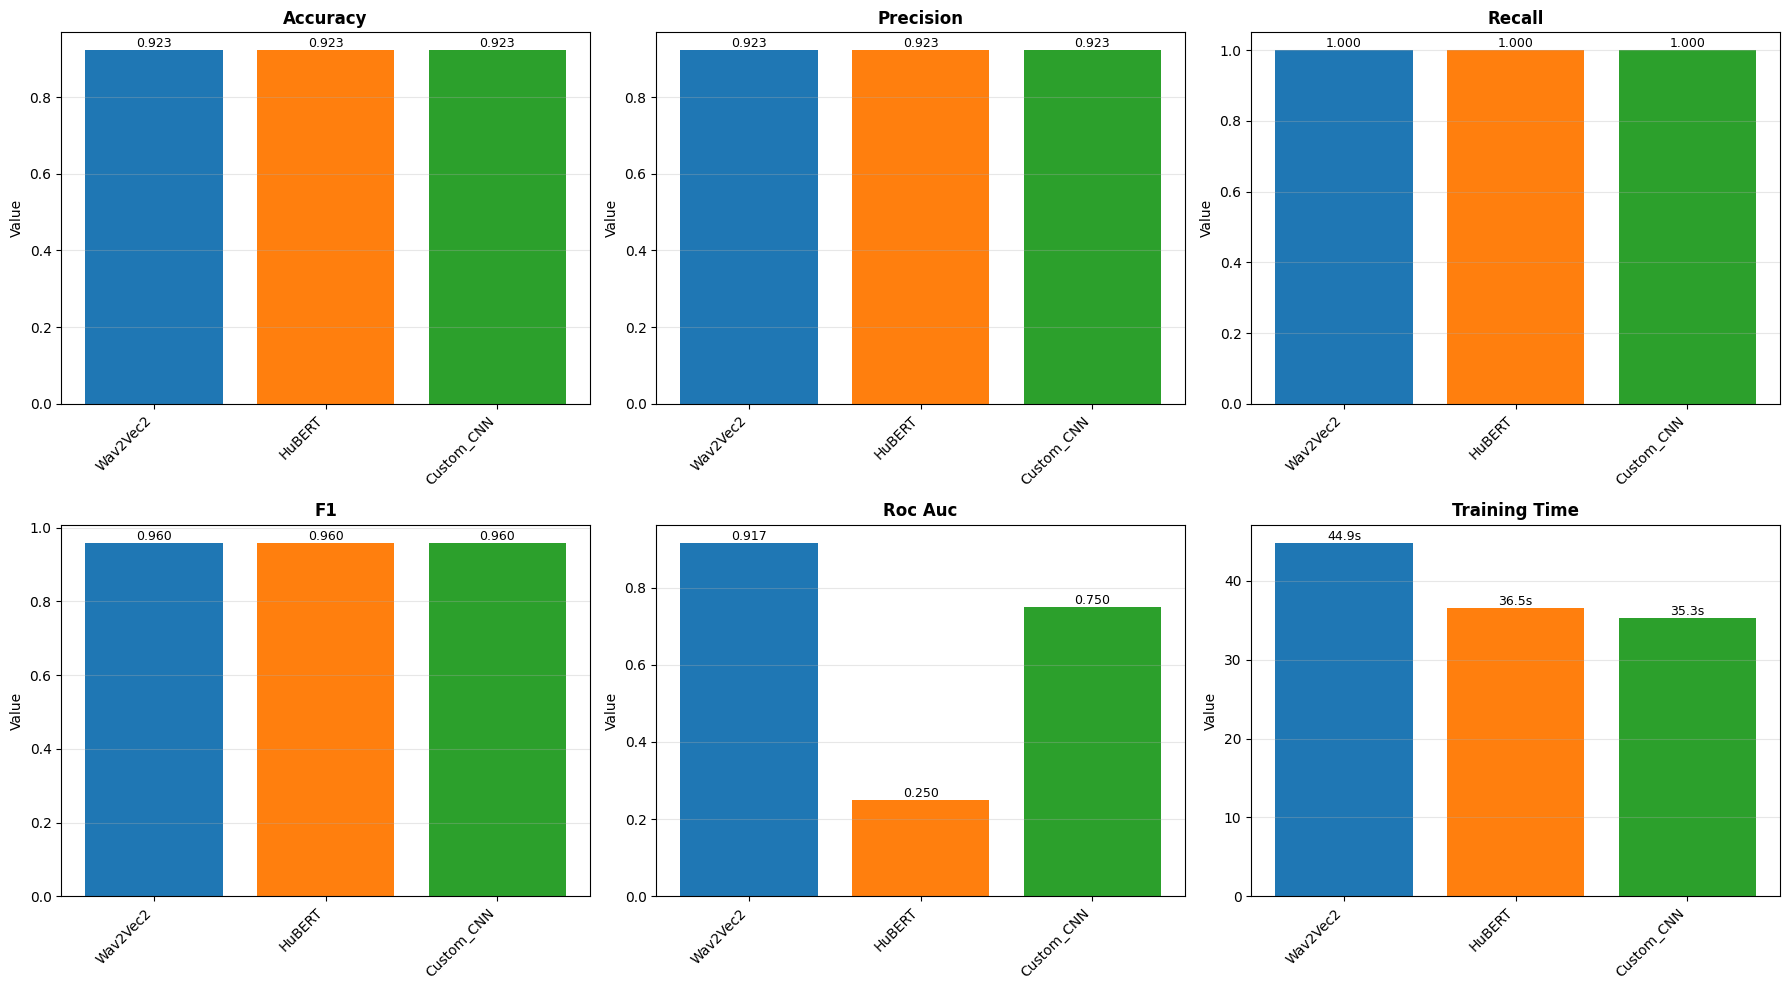

Saved comparison plot!


In [20]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'training_time']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = [results[model][metric] for model in results.keys()]
    bars = ax.bar(results.keys(), values, color=colors)
    ax.set_title(f'{metric.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        if metric == 'training_time':
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}s', ha='center', va='bottom', fontsize=9)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('audio_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved comparison plot!")

In [21]:
# Save results
comparison_df.to_csv('audio_baseline_results.csv')
print("Results saved to 'audio_baseline_results.csv'")

best_model_name = comparison_df['accuracy'].idxmax()
print(f"\nBest model: {best_model_name}")
print(f"Best accuracy: {comparison_df.loc[best_model_name, 'accuracy']:.4f}")

Results saved to 'audio_baseline_results.csv'

Best model: Wav2Vec2
Best accuracy: 0.9231


In [22]:
# Save the best audio model
best_model_name = comparison_df['accuracy'].idxmax()
print(f"Saving best model: {best_model_name}")

if best_model_name == 'Wav2Vec2':
    torch.save(wav2vec2_trained.state_dict(), 'best_audio_model_wav2vec2.pth')
elif best_model_name == 'HuBERT':
    torch.save(hubert_trained.state_dict(), 'best_audio_model_hubert.pth')
elif best_model_name == 'Custom_CNN':
    torch.save(cnn_trained.state_dict(), 'best_audio_model_cnn.pth')

print(f"Best audio model saved successfully!")

Saving best model: Wav2Vec2
Best audio model saved successfully!


## Conclusion

### Key Findings:
1. **Self-supervised models** (Wav2Vec2, HuBERT) leverage large-scale pretraining
2. **Custom CNN** provides a lightweight baseline for comparison
3. **Audio features** capture artifacts from voice synthesis and conversion

### Next Steps:
- Combine audio features with visual features for multimodal detection
- Explore temporal modeling across longer audio sequences
- Test on different types of audio deepfakes (TTS, voice conversion, etc.)

### Observations:
- Transformer-based models capture contextual information better
- Audio deepfakes have distinct spectral characteristics
- Smaller dataset size may limit fine-tuning potential